<a href="https://colab.research.google.com/github/hyunjaec/MScA_Machine_Learning_Project/blob/main/medical_deepfakes_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
#!pip install pydicom
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import pydicom 
import scipy.ndimage
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = os.listdir(dicom_folder)
    first_slice_data = pydicom.read_file(os.path.join(path2scan_dir,dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient) #zyx format
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = np.float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]]) #zyx format

    scan = np.zeros((len(dcms),first_slice.shape[0],first_slice.shape[1]))
    raw_slices=[]
    indexes = []
    for dcm in dcms:
        slice_data = pydicom.read_file(os.path.join(dicom_folder,dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    indexes = np.array(indexes,dtype=float)

    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    origin = np.array(raw_slices[0][0x00200032].value) #origin is assumed to be the image location of the first slice
    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.array([origin[2],origin[1],origin[0]]) #change from x,y,z to z,y,x

    for i, slice in enumerate(raw_slices):
        scan[i, :, :] = slice.pixel_array
    return scan, spacing, orientation, origin, raw_slices

In [4]:
scan_uuid = 1280
scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/Data/medical_deepfakes/CT_Scans/EXP1_blind/'+str(scan_uuid))

print('The CT scan has the dimensions of',scan.shape,'  (z,y,x)')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


The CT scan has the dimensions of (133, 512, 512)   (z,y,x)


In [6]:
df = pd.read_csv('/content/drive/My Drive/Data/medical_deepfakes/labels_exp1.csv')
locations = df.loc[df['uuid']==scan_uuid]
locations

,type,uuid,slice,x,y
0,FB,1280,100,323,381


In [7]:
def cutCube(X, center, shape, padd=0): #center is a 3d coord (zyx)
    center = center.astype(int)
    hlz = np.round(shape[0] / 2)
    hly = np.round(shape[1] / 2)
    hlx = np.round(shape[2] / 2)

    #add padding if out of bounds
    if ((center - np.array([hlz,hly,hlx])) < 0).any() or (
        (center + np.array([hlz,hly,hlx]) + 1) > np.array(X.shape)).any():  # if cropping is out of bounds, add padding
        try:
          np.ones(np.array(X.shape) + shape * 2)
        except:
          return "No"
        Xn = np.ones(np.array(X.shape) + shape * 2) * padd
        Xn[shape[0]:(shape[0] + X.shape[0]), shape[1]:(shape[1] + X.shape[1]), shape[2]:(shape[2] + X.shape[2])] = X
        centern = center + shape
        cube = Xn[int(centern[0] - hlz):int(centern[0] - hlz + shape[0]),
               int(centern[1] - hly):int(centern[1] - hly + shape[1]),
               int(centern[2] - hlx):int(centern[2] - hlx + shape[2])]
        return np.copy(cube)
    else:
        cube = X[int(center[0] - hlz):int(center[0] - hlz + shape[0]), int(center[1] - hly):int(center[1] - hly + shape[1]),
               int(center[2] - hlx):int(center[2] - hlx + shape[2])]
        return np.copy(cube)


In [9]:
import os
dir = "/content/drive/My Drive/Data/medical_deepfakes/CT_Scans/EXP1_blind/"
r=[]
for root, dirs, files in os.walk(dir):
  r.append(root)

In [10]:
label_df = pd.read_csv('/content/drive/My Drive/Data/medical_deepfakes/Response EXP1 - AI_instances.csv')
df_true = label_df.loc[label_df['label']==True]
df_false = label_df.loc[label_df['label']==False]

In [11]:
df_true.uuid[0]

1280

In [12]:
df_true = df_true.reset_index()
df_false = df_false.reset_index()

In [13]:
def image_cut_processing(df):
  cut_cubes = []
  for i in range(0,len(df)):
    scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/Data/medical_deepfakes/CT_Scans/EXP1_blind/'+str(df.uuid[i]))
    uuid_row = df.loc[df['uuid'] == df.uuid[i]]
    for j in range(len(uuid_row)):
      location = uuid_row.iloc[j]
      coord = np.array([location['slice'],location['y'],location['x']])
      if (cutCube(scan,coord,(64,64,64))) != "No":
        cut_cubes.append(cutCube(scan,coord,(64,64,64)))
  return cut_cubes
  

In [14]:
true_cut_images = image_cut_processing(df_true)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [15]:
false_cut_images = image_cut_processing(df_false)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [99]:
list1 = [True for i in range(219)]
list2 = [False for i in range(41)]
y = list1+list2
y = np.array(y)

In [80]:
# y = y*1

In [100]:
y = pd.get_dummies(y)

In [101]:
X = true_cut_images +false_cut_images

In [102]:
len(X)

260

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [104]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [105]:
X_train = X_train.reshape(208, 262144)
X_test = X_test.reshape(52, 262144)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (208, 262144)
Testing matrix shape (52, 262144)


In [107]:
from keras.utils import np_utils

In [109]:
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

In [123]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

In [158]:
model = Sequential()
model.add(Dense(512, input_shape=(262144,)))
model.add(Activation('relu')) 
 
# Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dropout(0.2))   

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))

In [159]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               134218240 
                                                                 
 activation_27 (Activation)  (None, 512)               0         
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 activation_28 (Activation)  (None, 512)               0         
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 2)                

In [160]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [161]:
history = model.fit(X_train, y_train,
          batch_size=52, epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/50
4/4 [==============================] - 1s 117ms/step - loss: 638.9181 - accuracy: 0.5577 - val_loss: 538.9929 - val_accuracy: 0.7885
Epoch 2/50
4/4 [==============================] - 0s 61ms/step - loss: 471.7352 - accuracy: 0.8558 - val_loss: 379.1084 - val_accuracy: 0.7885
Epoch 3/50
4/4 [==============================] - 0s 58ms/step - loss: 258.7431 - accuracy: 0.6154 - val_loss: 95.9076 - val_accuracy: 0.7885
Epoch 4/50
4/4 [==============================] - 0s 60ms/step - loss: 219.1762 - accuracy: 0.8654 - val_loss: 356.4852 - val_accuracy: 0.7885
Epoch 5/50
4/4 [==============================] - 0s 65ms/step - loss: 148.3559 - accuracy: 0.8510 - val_loss: 31.6200 - val_accuracy: 0.7500
Epoch 6/50
4/4 [==============================] - 0s 60ms/step - loss: 131.2750 - accuracy: 0.6827 - val_loss: 88.4422 - val_accuracy: 0.7885
Epoch 7/50
4/4 [==============================] - 0s 60ms/step - loss: 106.1976 - accuracy: 0.8606 - val_loss: 117.2119 - val_accuracy: 0.7885
E

In [162]:
score = model.evaluate(X_test, y_test,verbose=1)

print('Test loss:', score)

2/2 [==============================] - 0s 13ms/step - loss: 6.9301 - accuracy: 0.9231
Test loss: [6.930084705352783, 0.9230769276618958]


Text(0.5, 1.0, 'Loss Curves')

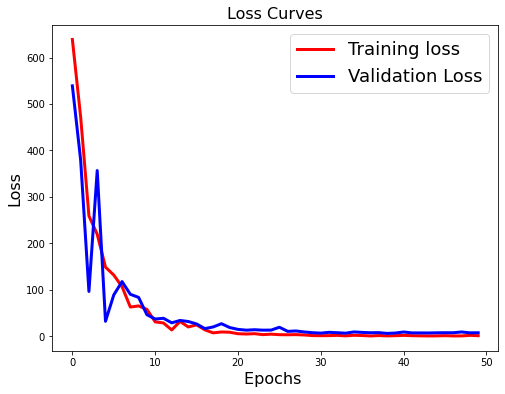

In [163]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [165]:
predicted_classes = model.predict(X_test)
#print(predicted_classes)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

print(correct_indices)
print(incorrect_indices)

[ 0  1  1  2  2  4  4  5  6  6  7  7  9  9 10 10 11 12 12 13 13 15 15 19
 19 20 21 22 22 23 23 24 25 25 26 26 27 29 30 30 31 31 32 32 33 33 34 37
 37 38 39 40 41 41 42 42 43 43 44 45 45 46 46 47 47 48 48 49 50 51]
[ 0  3  3  5  8  8 11 14 14 16 16 17 17 18 18 20 21 24 27 28 28 29 34 35
 35 36 36 38 39 40 44 49 50 51]
